In [1]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --ignore-installed --upgrade tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/9e/b8/ed5f794359d05cd0bffb894c6418da87b93016ee17b669d55c45d1bd5d5b/tensorflow-2.13.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.13.0-cp311-cp311-win_amd64.whl.metadata (2.6 kB)
  Obtaining dependency information for tensorflow-intel==2.13.0 from https://files.pythonhosted.org/packages/2f/2f/3c84f675931ce3bcbc7e23acbba1e5d7f05ce769adab48322de57a9f5928/tensorflow_intel-2.13.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.13.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Obtaining dependency information for flatbuffers>=23.1.21 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Using cached flatbuffers-23.5.26-py2.py3-none-any.

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\mrg22-020914479\\.conda\\envs\\TestDL\\Lib\\site-packages\\markupsafe\\_speedups.cp311-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [4]:
# Essential and common packages
import os
import glob
import sklearn

# Read and visualize the raster data
import rasterio
from rasterio.plot import show

# Plots and bars
import matplotlib.pyplot as plt
import seaborn as sns

# Computation library
import numpy as np

# Tensorflow for building the resnet50 model
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

# Sklearn for confusion matrix
import itertools
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix

# For visualization of plots without plt.show()
%matplotlib inline

In [5]:
dataset_url = r'C:\Users\mrg22-020914479\Downloads\2750'
batch_size = 32
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


In [7]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [8]:
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


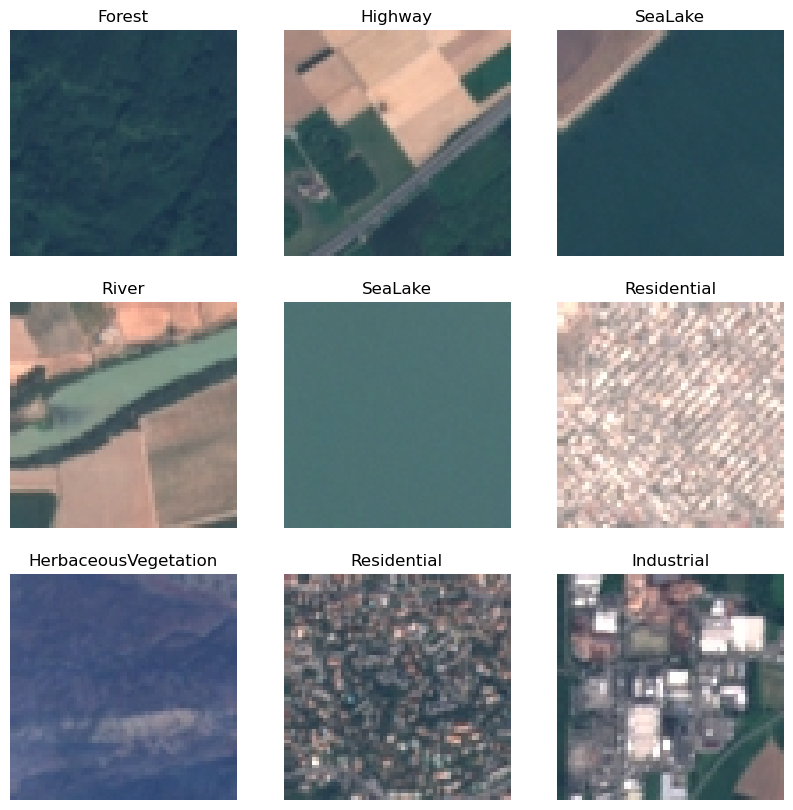

In [9]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(5):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [11]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [12]:
def ResNet50(input_shape = (64, 64, 3), classes = 10):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
Model Train

In [13]:
model = ResNet50(input_shape=(64,64,3), classes=10)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']          

                                                                    ]                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 15, 15, 64)           36928     ['activation_7[0][0]']        
                                                                                                  
 batch_normalization_9 (Bat  (None, 15, 15, 64)           256       ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_8 (Activation)   (None, 15, 15, 64)           0         ['batch_normalization_9[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_10

 batch_normalization_18 (Ba  (None, 8, 8, 128)            512       ['conv2d_18[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_16 (Activation)  (None, 8, 8, 128)            0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 8, 8, 128)            147584    ['activation_16[0][0]']       
                                                                                                  
 batch_normalization_19 (Ba  (None, 8, 8, 128)            512       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
          

 activation_24 (Activation)  (None, 4, 4, 1024)           0         ['add_7[0][0]']               
                                                                                                  
 conv2d_28 (Conv2D)          (None, 4, 4, 256)            262400    ['activation_24[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 4, 4, 256)            1024      ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_25 (Activation)  (None, 4, 4, 256)            0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_29

 conv2d_37 (Conv2D)          (None, 4, 4, 256)            262400    ['activation_33[0][0]']       
                                                                                                  
 batch_normalization_37 (Ba  (None, 4, 4, 256)            1024      ['conv2d_37[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_34 (Activation)  (None, 4, 4, 256)            0         ['batch_normalization_37[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 4, 4, 256)            590080    ['activation_34[0][0]']       
                                                                                                  
 batch_nor

                                                                    ']                            
                                                                                                  
 activation_42 (Activation)  (None, 2, 2, 2048)           0         ['add_13[0][0]']              
                                                                                                  
 conv2d_47 (Conv2D)          (None, 2, 2, 512)            1049088   ['activation_42[0][0]']       
                                                                                                  
 batch_normalization_47 (Ba  (None, 2, 2, 512)            2048      ['conv2d_47[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_43 (Activation)  (None, 2, 2, 512)            0         ['batch_normalization_47[0][0]
          

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# please increase the epoch for higher accuracy (epochs=100)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=20, batch_size=32)

Epoch 1/20
675/675 [==============================] - 1385s 2s/step - loss: 1.6330 - accuracy: 0.5133 - val_loss: 1.4265 - val_accuracy: 0.5554
Epoch 2/20
675/675 [==============================] - 943s 1s/step - loss: 1.0458 - accuracy: 0.6597 - val_loss: 1.0841 - val_accuracy: 0.6478
Epoch 3/20
675/675 [==============================] - 916s 1s/step - loss: 0.8745 - accuracy: 0.7162 - val_loss: 1.1274 - val_accuracy: 0.6319
Epoch 4/20
675/675 [==============================] - 910s 1s/step - loss: 0.8003 - accuracy: 0.7431 - val_loss: 1.0446 - val_accuracy: 0.7137
Epoch 5/20
675/675 [==============================] - 912s 1s/step - loss: 0.7529 - accuracy: 0.7597 - val_loss: 1.2954 - val_accuracy: 0.5931
Epoch 6/20
675/675 [==============================] - 902s 1s/step - loss: 0.6586 - accuracy: 0.7893 - val_loss: 0.7317 - val_accuracy: 0.7450
Epoch 7/20
675/675 [==============================] - 904s 1s/step - loss: 0.6402 - accuracy: 0.7947 - val_loss: 1.1801 - val_accuracy: 0.649

In [18]:
model.save('lulc_20_epoch')

INFO:tensorflow:Assets written to: lulc_20_epoch\assets


INFO:tensorflow:Assets written to: lulc_20_epoch\assets


In [20]:
from tensorflow.keras.models import load_model

In [21]:
model=load_model('lulc_20_epoch')

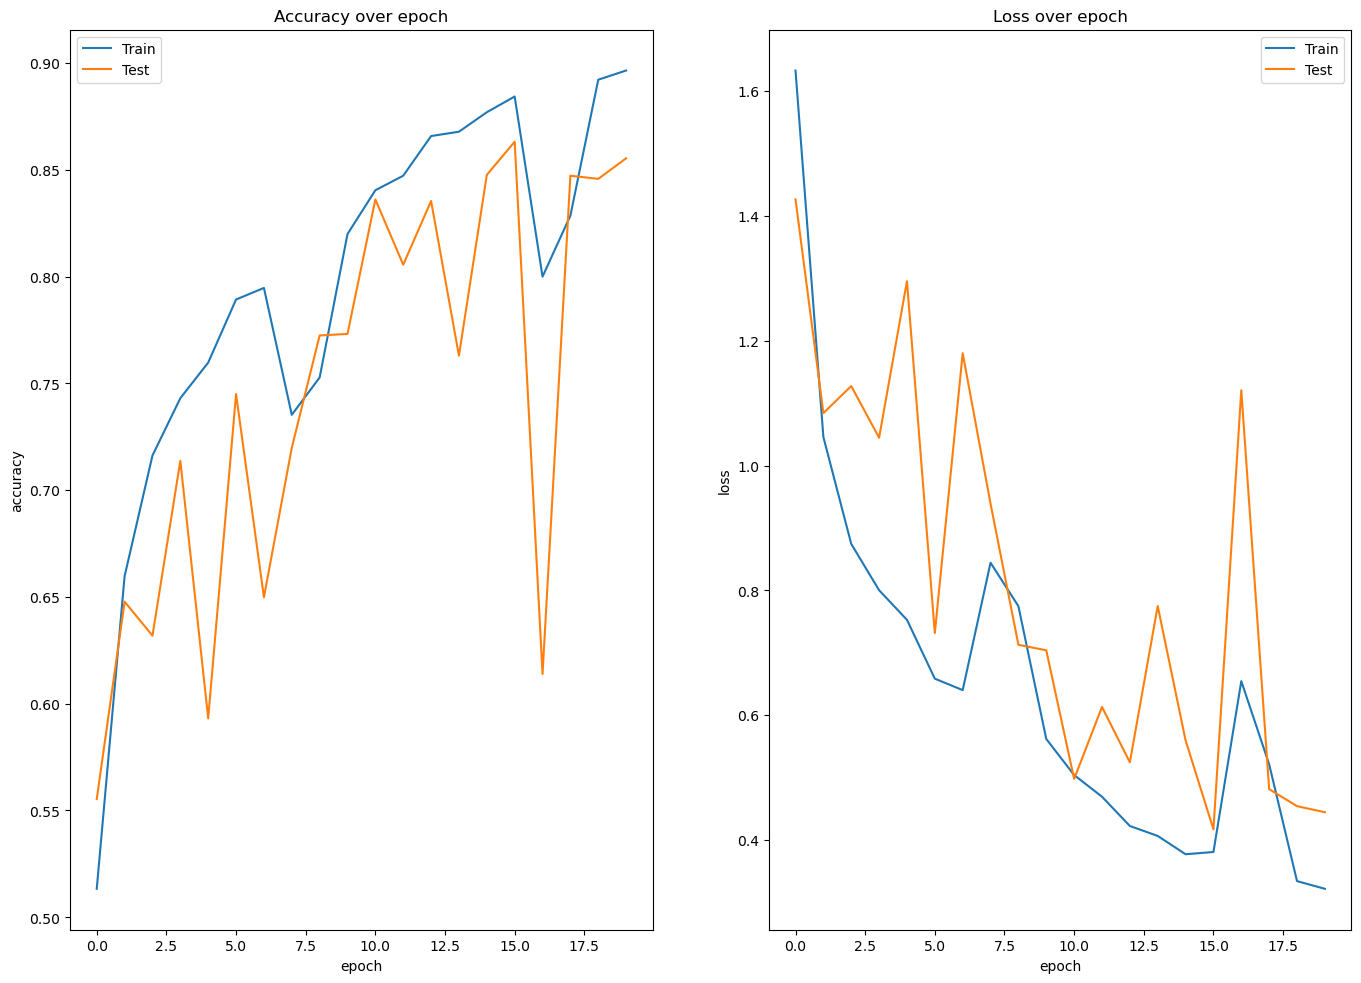

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

In [25]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[ 851,    4,   44,   52,    1,   30,   39,    0,   20,   23],
       [   0,  963,   18,    1,    0,   57,   11,    0,   11,   13],
       [  19,   17,  899,   24,    4,   13,   64,    7,   16,    5],
       [  20,    0,   16,  714,   43,   25,   41,   13,   37,    0],
       [   1,    0,    8,   13,  840,    0,    2,   19,    3,    0],
       [   9,    8,   26,   14,    0,  586,   31,    0,   21,   11],
       [  47,    0,  100,   54,   12,   26,  627,    3,   35,    0],
       [   0,    0,   14,   10,   46,    1,   20,  981,    1,    0],
       [  32,    7,   10,   68,    1,   32,    6,    0,  729,    8],
       [   5,   17,    1,    0,    0,    9,    0,    0,    5, 1010]],
      dtype=int64)

In [24]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[ 851,    4,   44,   52,    1,   30,   39,    0,   20,   23],
       [   0,  963,   18,    1,    0,   57,   11,    0,   11,   13],
       [  19,   17,  899,   24,    4,   13,   64,    7,   16,    5],
       [  20,    0,   16,  714,   43,   25,   41,   13,   37,    0],
       [   1,    0,    8,   13,  840,    0,    2,   19,    3,    0],
       [   9,    8,   26,   14,    0,  586,   31,    0,   21,   11],
       [  47,    0,  100,   54,   12,   26,  627,    3,   35,    0],
       [   0,    0,   14,   10,   46,    1,   20,  981,    1,    0],
       [  32,    7,   10,   68,    1,   32,    6,    0,  729,    8],
       [   5,   17,    1,    0,    0,    9,    0,    0,    5, 1010]],
      dtype=int64)

In [26]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 851    4   44   52    1   30   39    0   20   23]
 [   0  963   18    1    0   57   11    0   11   13]
 [  19   17  899   24    4   13   64    7   16    5]
 [  20    0   16  714   43   25   41   13   37    0]
 [   1    0    8   13  840    0    2   19    3    0]
 [   9    8   26   14    0  586   31    0   21   11]
 [  47    0  100   54   12   26  627    3   35    0]
 [   0    0   14   10   46    1   20  981    1    0]
 [  32    7   10   68    1   32    6    0  729    8]
 [   5   17    1    0    0    9    0    0    5 1010]]


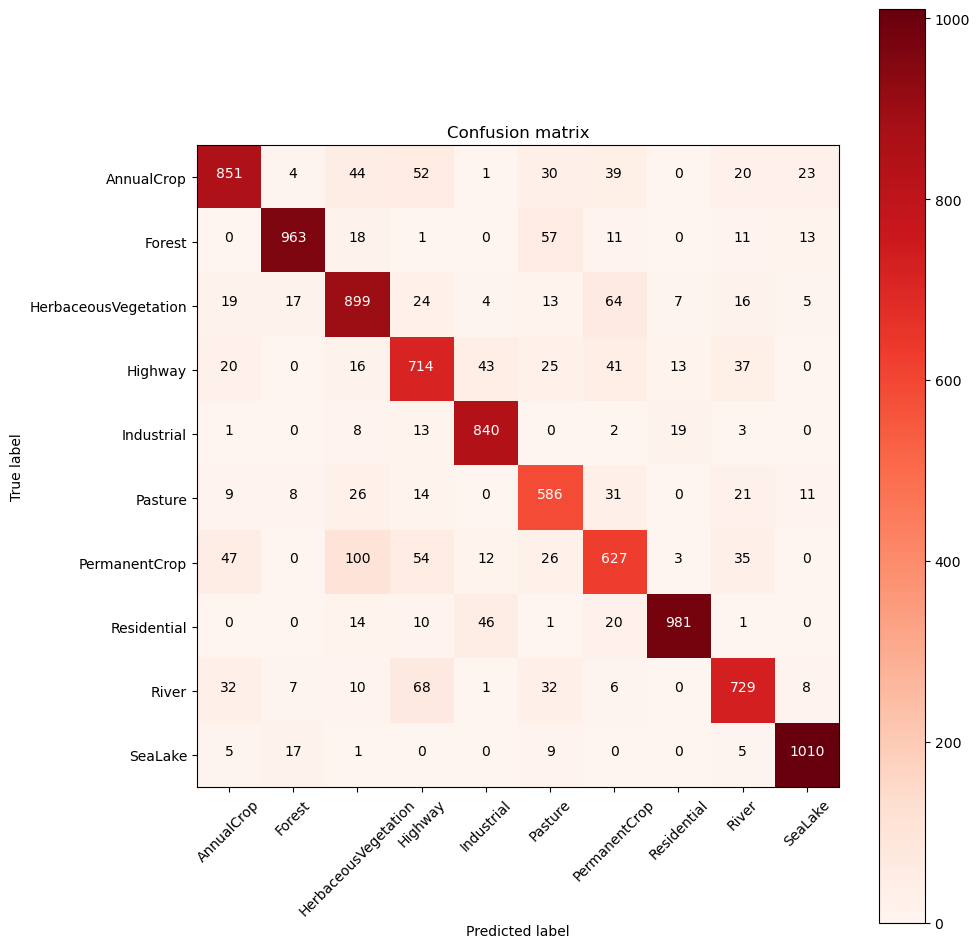

In [27]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Reds')